# [NLP] Korean-English Translator Using Transformer Model


## Rubric

| Rubric | Criteria |
| --- | --- |
| 1. Text data preprocessing for the translator model was done well. | Data cleaning, tokenization with SentencePiece, and dataset construction were completed as instructed. |
| 2. The Transformer translator model runs correctly. | The Transformer model's training and inference processes worked correctly, and the Korean-English translation function operates properly. |
| 3. The test results produced meaningful translations. | Plausible English translations were generated for the given Korean sentences. |


# Step 1. Import Libraries and Load Data


In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

%config InlineBackend.figure_format = 'retina'
 
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

'/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import re
import os
import io
import time
import random

import seaborn # Attention 시각화를 위해 필요!

print(tf.__version__)

2.8.0


In [5]:
kor_path = '/content/drive/MyDrive/AIFFEL/seq2seq/korean-english-park.train.ko'
eng_path = '/content/drive/MyDrive/AIFFEL/seq2seq/korean-english-park.train.en'

In [6]:
with open(kor_path, "r") as f: kor = f.read().splitlines()
with open(eng_path, "r") as f: eng = f.read().splitlines()
print("Data Size:({},{})".format(len(kor), len(eng)))
print("Example:")

cnt = 0
for ko, en in zip(kor, eng):
    print(f">>\n한국어 : {ko}\n영어 : {en}\n")
    cnt += 1
    if cnt == 5:
        break

Data Size:(94123,94123)
Example:
>>
한국어 : 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
영어 : Much of personal computing is about "can you top this?"

>>
한국어 : 모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하지 않는다.
영어 : so a mention a few weeks ago about a rechargeable wireless optical mouse brought in another rechargeable, wireless mouse.

>>
한국어 : 그러나 이것은 또한 책상도 필요로 하지 않는다.
영어 : Like all optical mice, But it also doesn't need a desk.

>>
한국어 : 79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분이든 그 움직임에따라 커서의 움직임을 조절하는 회전 운동 센서를 사용하고 있다.
영어 : uses gyroscopic sensors to control the cursor movement as you move your wrist, arm, whatever through the air.

>>
한국어 : 정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔음을 밝혔으며, 세계 해상 교역량의 거의 3분의 1을 운송하는 좁은 해로인 말라카 해협이 테러 공격을 당하기 쉽다고 경고하고 있다.
영어 : Intelligence officials have revealed a spate of foiled plots on ships in Southeast Asia and are warning that a narrow stretch of water carrying almost one third of the world's maritime trade is vulnerable to a terror atta

## Step 2. Data Cleaning and Tokenization

## 2-1 Remove Duplicate Data


In [7]:
def clean_corpus(kor,eng):
  assert len(kor) == len(eng)
  cleaned_corpus = list(set(zip(kor, eng)))

  return cleaned_corpus

In [8]:
cleaned_corpus = clean_corpus(kor,eng)
len(cleaned_corpus)

78968

## 2-2 Define Cleaning Function

- Convert all input to lowercase.
- Keep only alphabets, punctuation, and Korean characters; remove everything else.
- Add spaces around punctuation marks.
- Remove unnecessary whitespace at the beginning and end of sentences.


In [9]:
def preprocess_sentence(sentence):
  sentence = sentence.lower()
  sentence = re.sub(r"[^a-zA-Zㄱ-ㅎㅏ-ㅣ가-힣?.!,]+", " ", sentence) 
  sentence = re.sub(r'[" "]+', " ",sentence) # 여러개의 공백은 하나의 공백으로 바꿈
  sentence = sentence.strip() 
  return sentence

# 2-3 Tokenization

- Separate the corpus into kor_corpus and eng_corpus, then clean and tokenize.
- Use SentencePiece for tokenization.
- Define the generate_tokenizer() function to obtain ko_tokenizer and en_tokenizer.
- Apply set_encode_extra_options("bos:eos") to en_tokenizer so that target inputs include start and end tokens.
- Accept the vocabulary as a parameter to create a dictionary of the desired size.


In [10]:
def generate_tokenizer(corpus, model_type='unigram', vocab_size=32000, lang="ko"): 
    
    input_file = f'{lang}_spm_input.txt'

    with open(input_file, 'w', encoding='utf-8') as f:
        for sent in corpus:
            f.write('{}\n'.format(sent))
        
    sp_model_root='sentencepiece'
    if not os.path.isdir(sp_model_root): os.mkdir(sp_model_root)
    
    prefix = 'tokenizer_%s_%s' % (lang,model_type+str(vocab_size))
    prefix = os.path.join(sp_model_root, prefix) # 저장될 tokenizer 모델에 붙는 이름
    pad_id=0
    bos_id=1 #<start> token을 1으로 설정
    eos_id=2 #<end> token을 2으로 설정
    unk_id=3 #<unknown> token을 3으로 설정
    character_coverage = 1.0 # to reduce character set 
    # model_type = model_type # Choose from unigram (default), bpe, char, or word
    input_argument = '--input=%s --pad_id=%s --bos_id=%s --eos_id=%s --unk_id=%s --model_prefix=%s --vocab_size=%s --character_coverage=%s --model_type=%s'
    cmd = input_argument%(input_file, pad_id, bos_id, eos_id, unk_id, prefix, vocab_size, character_coverage, model_type)
                      
    spm.SentencePieceTrainer.Train(cmd)
    tokenizer = spm.SentencePieceProcessor()
    tokenizer.Load(f'{prefix}.model')
    
    return tokenizer

In [11]:
cleaned_corpus[0]

('매튜 코르랜 국제적십자사연맹(International Federation of the Red Cross and Red Crescent Societies) 대변인은 적십자에서도 구호물품 판매에 대한 보고를 받지 않았다고 밝혔다.',
 'International Federation of Red Cross and Red Crescent Societies spokesman Matthew Cochrane said the organization also had not received any such reports.')

In [12]:
# !pip uninstall sentencepiece
!pip install sentencepiece

     |████████████████████████████████| 1.2 MB 4.3 MB/s 


In [13]:
import sentencepiece as spm


SRC_VOCAB_SIZE = TGT_VOCAB_SIZE = 32000

eng_corpus = []
kor_corpus = []

for pair in cleaned_corpus:
    k, e = pair[0],pair[1]

    kor_corpus.append(preprocess_sentence(k))
    eng_corpus.append(preprocess_sentence(e))

ko_tokenizer = generate_tokenizer(kor_corpus, 'unigram', SRC_VOCAB_SIZE, "ko")
en_tokenizer = generate_tokenizer(eng_corpus, 'unigram', TGT_VOCAB_SIZE, "en")
en_tokenizer.set_encode_extra_options("bos:eos")

True

In [14]:
ko_test_txts = ['나와즈 샤리프 전 총리가 부토 전 총리 암살 후 조문을 위해 병원을 방문하자 병원 안은 혼잡해졌다.']
en_test_txts = ['Chaos erupted at the hospital when former Prime Minister Nawaz Sharif arrived to pay his respects to Bhutto less than three hours after her death.']

In [15]:
def tokensample(sp, txts):
  token_list =[]
  for txt in txts:
    tokens = sp.encode_as_pieces(txt)
    token_list.append(tokens)
  return token_list

In [16]:
tokensample(ko_tokenizer, ko_test_txts)

[['▁나와즈',
  '▁샤리프',
  '▁전',
  '▁총리가',
  '▁부토',
  '▁전',
  '▁총리',
  '▁암살',
  '▁후',
  '▁조문',
  '을',
  '▁위해',
  '▁병원',
  '을',
  '▁방문',
  '하자',
  '▁병원',
  '▁안',
  '은',
  '▁혼잡',
  '해졌다',
  '.']]

In [17]:
tokensample(en_tokenizer, en_test_txts)

[['<s>',
  '▁',
  'C',
  'ha',
  'os',
  '▁erupted',
  '▁at',
  '▁the',
  '▁hospital',
  '▁when',
  '▁former',
  '▁',
  'P',
  'rime',
  '▁',
  'M',
  'in',
  'ister',
  '▁',
  'N',
  'a',
  'waz',
  '▁',
  'S',
  'har',
  'if',
  '▁arrived',
  '▁to',
  '▁pay',
  '▁his',
  '▁respects',
  '▁to',
  '▁',
  'B',
  'hut',
  'to',
  '▁less',
  '▁than',
  '▁three',
  '▁hours',
  '▁after',
  '▁her',
  '▁death',
  '.',
  '</s>']]

## 2-4 Data Selection

- Using the tokenizer, select data where token length is 50 or less and build src_corpus and tgt_corpus respectively.
- Then convert to tensors enc_train and dec_train.


In [18]:
from tqdm.notebook import tqdm    # Process 과정을 보기 위해

src_corpus = []
tgt_corpus = []

assert len(kor_corpus) == len(eng_corpus)

#- 토큰의 길이가 50 이하인 문장만 남깁니다. 
for idx in tqdm(range(len(kor_corpus))):
    src = ko_tokenizer.EncodeAsIds(kor_corpus[idx])
    tgt = en_tokenizer.EncodeAsIds(eng_corpus[idx])
    
    if len(src) <= 50 and len(tgt) <= 50 :
        src_corpus.append(src)
        tgt_corpus.append(tgt)

#- 패딩처리를 완료하여 학습용 데이터를 완성합니다. 
enc_train = tf.keras.preprocessing.sequence.pad_sequences(src_corpus, padding='post')
dec_train = tf.keras.preprocessing.sequence.pad_sequences(tgt_corpus, padding='post')

  0%|          | 0/78968 [00:00<?, ?it/s]

# Step 3. Model Design


## 3-1 Positional Encoding

In [19]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    return sinusoid_table


## 3-2 Multi-Head Attention

Multi-Head Attention is built by combining several sub-modules: split_heads() which splits the embedded input by the number of heads, scaled_dot_product_attention() which computes attention values from the split input, and combine_heads() which merges the split heads back together after computation. These are all encapsulated in the MultiHeadAttention class.


In [20]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        self.depth = d_model // self.num_heads
        
        self.W_q = tf.keras.layers.Dense(d_model)  
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
        
        self.linear = tf.keras.layers.Dense(d_model)
    
    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        
        QK = tf.matmul(Q, K, transpose_b=True)
        scaled_qk = QK / tf.math.sqrt(d_k)
        
        if mask is not None:
            scaled_qk += (mask * -1e9)
        
        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)
        return out, attentions 
    
    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        
        # Scaled QK 값 구하기
        QK = tf.matmul(Q, K, transpose_b=True)
        scaled_qk = QK / tf.math.sqrt(d_k)
        
        if mask is not None:
            scaled_qk += (mask * -1e9)
        
        # 1. Attention Weights 값 구하기 -> attentions
        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        # 2. Attention 값을 V에 곱하기 -> out
        out = tf.matmul(attentions, V)
        return out, attentions
    
    def split_heads(self, x):
        """
        Embedding된 입력을 head의 수로 분할하는 함수
        
        x: [ batch x length x emb ]
        return: [ batch x length x heads x self.depth ]
        """
        bsz = x.shape[0]
        split_x = tf.reshape(x, (bsz, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])
        return split_x
    
    def combine_heads(self, x):
        """
        분할된 Embedding을 하나로 결합하는 함수
        
        x: [ batch x length x heads x self.depth ]
        return: [ batch x length x emb ]
        """
        bsz = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (bsz, -1, self.d_model))
        return combined_x
    
    def call(self, Q, K, V, mask):
        """
        Step 1: Linear_in(Q, K, V) -> WQ, WK, WV
        Step 2: Split Heads(WQ, WK, WV) -> WQ_split, WK_split, WV_split
        Step 3: Scaled Dot Product Attention(WQ_split, WK_split, WV_split)
                 -> out, attention_weights
        Step 4: Combine Heads(out) -> out
        Step 5: Linear_out(out) -> out
        """
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
        
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask
        )
        
        out = self.combine_heads(out)
        out = self.linear(out)
        
        return out, attention_weights
            

    def split_heads(self, x):
        batch_size = x.shape[0]
        split_x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        batch_size = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (batch_size, -1, self.d_model))

        return combined_x

        
    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
            
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)
    				        
        out = self.combine_heads(out)
        out = self.linear(out)
                
        return out, attention_weights

## 3-3 Position-wise Feed-Forward Network

In [21]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
            
        return out


d_ff follows the paper specification at 2048, and d_model is 512. An input of shape [batch x length x d_model] is mapped to 2048 dimensions by w_1, then the ReLU activation function is applied, and w_2 maps it back to 512 dimensions.


# Step 4. Module Assembly

Just as you would use TensorFlow's Dense layer, we define EncoderLayer and DecoderLayer as layer classes by inheriting from tf.keras.layers.Layer.


## 4-1 Implement Encoder Layer


In [22]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):

        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual
        
        return out, enc_attn

## 4-2 Implement Decoder Layer


In [23]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, causality_mask, padding_mask):

        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.dropout(out)
        out += residual

        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, causality_mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual

        return out, dec_attn, dec_enc_attn

In [24]:
class Encoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

In [25]:
class Decoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
                            
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

## 4-3 Complete the Transformer

Assemble the defined Encoder and Decoder to complete the Transformer!

Complete the Transformer class satisfying these conditions:

1. Accept a `shared` parameter: when True, share weights between the Decoder Embedding and the output Linear layer. When weights are shared, remember to multiply the Embedding values by sqrt(d_model).
2. The encoder receives (enc_input, enc_mask) and the decoder receives (dec_input, enc_output, dec_mask, enc_dec_mask).


In [26]:

class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared=True):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)

        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.dropout = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared = shared

        if shared: self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]
        out = emb(x)

        if self.shared: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.dropout(out)

        return out

        
    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, causality_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns

## 4-4 Masking

In [27]:
import numpy as np
import tensorflow as tf

def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask


- generate_padding_mask() prevents the model from attending to <PAD> tokens during attention computation.

- It generates a mask that identifies all <PAD> token positions in each batch.


# Step 5. Model Training

## 5-1 Model Declaration


In [30]:
# Layer를 가지는 Transformer를 선언함
 transformer = Transformer(
    n_layers=2,
    d_model=512,
    n_heads=8,
    d_ff=2048,
    src_vocab_size=SRC_VOCAB_SIZE,
    tgt_vocab_size=TGT_VOCAB_SIZE,
    pos_len=200,
    dropout=0.2,
    shared=True
)

## 5-2 Learning Rate Scheduler

- The first mask pads the tail portion of each batch. The unfamiliar parts are the second and third masks related to the Decoder, which combine the Causality Mask and Padding Mask.

- Just as we used causal masking in the Masked Multi-Head Attention to preserve the autoregressive property, the Decoder must also avoid <PAD> tokens, resulting in this combined mask format.

- The training function is decorated with @tf.function for GPU optimization in TensorFlow.


In [31]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

learning_rate = LearningRateScheduler(512)
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98, 
                                     epsilon=1e-9)


## 5-3 Define Loss Function and train_step Function


In [32]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    # Masking 되지 않은 입력의 개수로 Scaling하는 과정
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [33]:
@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    # 계산된 loss에 tf.GradientTape()를 적용해 학습을 진행합니다.
    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions[:, :-1])

    # 최종적으로 optimizer.apply_gradients()가 사용됩니다. 
    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return loss, enc_attns, dec_attns, dec_enc_attns

In [34]:
def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        import seaborn
        seaborn.heatmap(data, 
                        square=True,
                        vmin=0.0, vmax=1.0, 
                        cbar=False, ax=ax,
                        xticklabels=x,
                        yticklabels=y)
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Encoder Layer", layer + 1)
        for h in range(4):
            draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
        plt.show()
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Decoder Self Layer", layer+1)
        for h in range(4):
            draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
        plt.show()

        print("Decoder Src Layer", layer+1)
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        for h in range(4):
            draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()

In [35]:
# 번역 생성 함수

def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    sentence = preprocess_sentence(sentence)

    pieces = src_tokenizer.encode_as_pieces(sentence)
    tokens = src_tokenizer.encode_as_ids(sentence)

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')
    
    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns =\
        model(_input, 
              output,
              enc_padding_mask,
              combined_mask,
              dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = tgt_tokenizer.decode_ids(ids)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns

In [36]:
# 번역 생성 및 Attention 시각화 결합

def translate(sentence, model, src_tokenizer, tgt_tokenizer, plot_attention=False):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sentence, model, src_tokenizer, tgt_tokenizer)
    
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    if plot_attention:
        visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)

Setting the plot_attention parameter to True in the translate() function allows visualization of the Attention Map for the translation result.


## 5-4 Training


  0%|          | 0/1182 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama s president elect
Input: 시민들은 도시 속에 산다.
Predicted translation: the video is the world.
Input: 커피는 필요 없다.
Predicted translation: the study is not to be a.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the two days were killed in the city of the city of the city of the area.
Input: 투표는 시민의 권리이다
Predicted translation: the poll is the first time in the white house.
Input: 음주는 만성간염, 간경변증, 간암의 대표적인 원인이다.
Predicted translation: the company has been a hugely in the city of the city of the city of the country.
Input: 친환경 에너지 정책을 펼쳐온 미국 조 바이든 행정부가 올 들어 석탄 사용량을 늘린 것으로 나타났다.
Predicted translation: the nation s largest committee is expected to be the nation s largest economy, and the nation s largest economy.
Input: 박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다.
Predicted translation: the international group of the international community, the international of the international community, which is a year old.


  0%|          | 0/1182 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president.
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is the city of the city.
Input: 커피는 필요 없다.
Predicted translation: nobody doesn t need to make it harder.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the two thirds of the deaths were killed in the early morning.
Input: 투표는 시민의 권리이다
Predicted translation: the vote is not a vote.
Input: 음주는 만성간염, 간경변증, 간암의 대표적인 원인이다.
Predicted translation: the company has been a long range of years, and the company, and the company s health.
Input: 친환경 에너지 정책을 펼쳐온 미국 조 바이든 행정부가 올 들어 석탄 사용량을 늘린 것으로 나타났다.
Predicted translation: the energy department of energy and energy energy analyst said the u.s. economy is likely to be the first time in the united states.
Input: 박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다.
Predicted translation: park geun hye, who is the world s most influential people in the united kingdom, said he is the same way.


  0%|          | 0/1182 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is expected to show obama.
Input: 시민들은 도시 속에 산다.
Predicted translation: the city of urban city city city city of urban city.
Input: 커피는 필요 없다.
Predicted translation: the store has never been warm.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the deaths occurred sunday.
Input: 투표는 시민의 권리이다
Predicted translation: the vote is a resolution of the right to the right of the right to the right to the right of the right to the national election.
Input: 음주는 만성간염, 간경변증, 간암의 대표적인 원인이다.
Predicted translation: the drugs are being treated for the drug tests and the ruling, which has been blamed for the deaths of the drug.
Input: 친환경 에너지 정책을 펼쳐온 미국 조 바이든 행정부가 올 들어 석탄 사용량을 늘린 것으로 나타났다.
Predicted translation: the new york times reports that the united states will also reduce the risk of its kind of heart disease.
Input: 박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다.
Predicted translation: park, who was a former leader who was elected leader of the internatio

  0%|          | 0/1182 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a president.
Input: 시민들은 도시 속에 산다.
Predicted translation: residents are urban city.
Input: 커피는 필요 없다.
Predicted translation: no comment can need to do you need to do so.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the seven people were killed in the deaths.
Input: 투표는 시민의 권리이다
Predicted translation: the right right now is right right to the right.
Input: 음주는 만성간염, 간경변증, 간암의 대표적인 원인이다.
Predicted translation: the deal is the result of the deal, which is not seen as a result of the deal.
Input: 친환경 에너지 정책을 펼쳐온 미국 조 바이든 행정부가 올 들어 석탄 사용량을 늘린 것으로 나타났다.
Predicted translation: the first united states is the american and the administration is reporting that it is cutting power to power in the united states.
Input: 박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다.
Predicted translation: park s name, a few years ago, said he was shocked by the international dalai lama.


  0%|          | 0/1182 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the second.
Input: 시민들은 도시 속에 산다.
Predicted translation: they are urban to the city of the city.
Input: 커피는 필요 없다.
Predicted translation: no further details of the coffee.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the seven people were killed and eight people were injured thursday.
Input: 투표는 시민의 권리이다
Predicted translation: the polls is the right to rights.
Input: 음주는 만성간염, 간경변증, 간암의 대표적인 원인이다.
Predicted translation: drinking, which is between , and , have been a result of a smoke, and cause cancer.
Input: 친환경 에너지 정책을 펼쳐온 미국 조 바이든 행정부가 올 들어 석탄 사용량을 늘린 것으로 나타났다.
Predicted translation: the white house is pushing to pull a number of americans, the report says.
Input: 박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다.
Predicted translation: park was referring to as a international attention to the international space center in .


  0%|          | 0/1182 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a jon.
Input: 시민들은 도시 속에 산다.
Predicted translation: they re in the city of san francisco.
Input: 커피는 필요 없다.
Predicted translation: there is no need for coffee.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed tuesday in the seven deaths.
Input: 투표는 시민의 권리이다
Predicted translation: there is no right for those rights.
Input: 음주는 만성간염, 간경변증, 간암의 대표적인 원인이다.
Predicted translation: drinking is the time for the deaths, which has been critical to the liver, and has died.
Input: 친환경 에너지 정책을 펼쳐온 미국 조 바이든 행정부가 올 들어 석탄 사용량을 늘린 것으로 나타났다.
Predicted translation: among the use of energy as energy crops and obama are falling out of the energy to became coal and coal, according to a report by the u.s. government.
Input: 박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다.
Predicted translation: park s name for the organization of international mediators, who oversees the international monetary fund.


  0%|          | 0/1182 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a hard.
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is a great city.
Input: 커피는 필요 없다.
Predicted translation: coffee is no coffee.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed and injured.
Input: 투표는 시민의 권리이다
Predicted translation: there is a support right.
Input: 음주는 만성간염, 간경변증, 간암의 대표적인 원인이다.
Predicted translation: drinking alcohol is a factor for the deaths of between drinking, and a liver damage.
Input: 친환경 에너지 정책을 펼쳐온 미국 조 바이든 행정부가 올 들어 석탄 사용량을 늘린 것으로 나타났다.
Predicted translation: green energy sales and the u.s. backed comments, and the administration is looking to sell out for coal, and the administration said yesterday.
Input: 박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다.
Predicted translation: park was an ex door in the itself of a global consortium that was an international concern.


  0%|          | 0/1182 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: president barack obama is in his office.
Input: 시민들은 도시 속에 산다.
Predicted translation: city is offering entertainment in cities.
Input: 커피는 필요 없다.
Predicted translation: it s no coffee comment.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed in the seven seven deaths.
Input: 투표는 시민의 권리이다
Predicted translation: there is a right of support for the rights of the right people.
Input: 음주는 만성간염, 간경변증, 간암의 대표적인 원인이다.
Predicted translation: the drinking is for between between the parties, a critically damage to the cause of the emergency initiative and is a serious error.
Input: 친환경 에너지 정책을 펼쳐온 미국 조 바이든 행정부가 올 들어 석탄 사용량을 늘린 것으로 나타났다.
Predicted translation: thousands more have been thrownd into english and break the bush administration s power policy, with the thousands of dollars.
Input: 박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다.
Predicted translation: park is a former sex scandal like international gul has been based at internati

  0%|          | 0/1182 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a contesting obama s another president.
Input: 시민들은 도시 속에 산다.
Predicted translation: so they did in the city of san francisco.
Input: 커피는 필요 없다.
Predicted translation: it s coffee at the height of should be your coffee.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other people died seven of injuries friday.
Input: 투표는 시민의 권리이다
Predicted translation: the support is the right of the acts of right.
Input: 음주는 만성간염, 간경변증, 간암의 대표적인 원인이다.
Predicted translation: the drinking age of , successor killed pope john travolta , people, friday, friday, friday.
Input: 친환경 에너지 정책을 펼쳐온 미국 조 바이든 행정부가 올 들어 석탄 사용량을 늘린 것으로 나타났다.
Predicted translation: he also stand firm weight, says power stations are watching a white house after hugo chavez presentedd with a major u.s. government spending.
Input: 박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다.
Predicted translation: pak kept there quite a medals at the theme park in .


  0%|          | 0/1182 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama will be another.
Input: 시민들은 도시 속에 산다.
Predicted translation: city people are mowing in the city.
Input: 커피는 필요 없다.
Predicted translation: coffee is no coffee.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other people were killed tuesday.
Input: 투표는 시민의 권리이다
Predicted translation: the votes are the right of thousand civilians.
Input: 음주는 만성간염, 간경변증, 간암의 대표적인 원인이다.
Predicted translation: the drinking age of between between , has been speaker, a key test announcement between the government and public dead.
Input: 친환경 에너지 정책을 펼쳐온 미국 조 바이든 행정부가 올 들어 석탄 사용량을 늘린 것으로 나타났다.
Predicted translation: among the things that read the first reported cases involving more than percent, the researchers said.
Input: 박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다.
Predicted translation: park, a few years ago, fdi s directors particularly korean.


  0%|          | 0/1182 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: president obama is in another hour.
Input: 시민들은 도시 속에 산다.
Predicted translation: city citizens are civilians in an city that city.
Input: 커피는 필요 없다.
Predicted translation: coffee is no need to store.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed in the raid.
Input: 투표는 시민의 권리이다
Predicted translation: there is a civilians
Input: 음주는 만성간염, 간경변증, 간암의 대표적인 원인이다.
Predicted translation: the drinking age of between may , has been parties a key part of the battle between coalition government and anas.
Input: 친환경 에너지 정책을 펼쳐온 미국 조 바이든 행정부가 올 들어 석탄 사용량을 늘린 것으로 나타났다.
Predicted translation: among the something that key to energy areas are making way across the world listens to a portuguese land demand.
Input: 박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다.
Predicted translation: park, a resident at the international concerns of the secular press system.


  0%|          | 0/1182 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama s.
Input: 시민들은 도시 속에 산다.
Predicted translation: so they laid down a mountain in the city.
Input: 커피는 필요 없다.
Predicted translation: there s no need for comment.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other people were killed tuesday, the spanish national disaster service reported.
Input: 투표는 시민의 권리이다
Predicted translation: a right is the right to think.
Input: 음주는 만성간염, 간경변증, 간암의 대표적인 원인이다.
Predicted translation: the drinking age of , party members, traveled sunday to a public hospital between the , suspect s social suspects.
Input: 친환경 에너지 정책을 펼쳐온 미국 조 바이든 행정부가 올 들어 석탄 사용량을 늘린 것으로 나타났다.
Predicted translation: thousands more have been comments to be published in the u.s. comments faster after a two year old growing u.s. administration in a assessment of speculation.
Input: 박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다.
Predicted translation: park s name was an international twin group since a lander was based in .


  0%|          | 0/1182 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president.
Input: 시민들은 도시 속에 산다.
Predicted translation: city of citizens are similar in the s.
Input: 커피는 필요 없다.
Predicted translation: coffee is no need.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed in the local election monday
Input: 투표는 시민의 권리이다
Predicted translation: the support is a right.
Input: 음주는 만성간염, 간경변증, 간암의 대표적인 원인이다.
Predicted translation: the drinking age of , birds have been police describe the dead victims of between the city and arizona sen. had announced friday.
Input: 친환경 에너지 정책을 펼쳐온 미국 조 바이든 행정부가 올 들어 석탄 사용량을 늘린 것으로 나타났다.
Predicted translation: among the something that produces white house, cnn has been missing since may as quickly as becoming coal, and scientists estimate that power and produce more money to produce the cold freedom of natural weapons.
Input: 박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다.
Predicted translation: pak also introduced the name of the international concerns t

  0%|          | 0/1182 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is on going to take president.
Input: 시민들은 도시 속에 산다.
Predicted translation: city of happy about the cities they did.
Input: 커피는 필요 없다.
Predicted translation: coffee no need at suffered.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other people died.
Input: 투표는 시민의 권리이다
Predicted translation: right is the right of civilian lisa claims.
Input: 음주는 만성간염, 간경변증, 간암의 대표적인 원인이다.
Predicted translation: the drinking alcohol tourism considering the december assassination of a new reduction, a result of the illness between the army and years of lasted cause liver cancer.
Input: 친환경 에너지 정책을 펼쳐온 미국 조 바이든 행정부가 올 들어 석탄 사용량을 늘린 것으로 나타났다.
Predicted translation: among the major shortages of energy and a half page report this year has been linked to a summit with produces designed to produce coal weapons.
Input: 박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다.
Predicted translation: park, who turns several years ago, was seen as a moderate directors of int

  0%|          | 0/1182 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president.
Input: 시민들은 도시 속에 산다.
Predicted translation: city citizens of them great.
Input: 커피는 필요 없다.
Predicted translation: coffee is no coffee.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven u.s. soldiers were killed.
Input: 투표는 시민의 권리이다
Predicted translation: the views of the right.
Input: 음주는 만성간염, 간경변증, 간암의 대표적인 원인이다.
Predicted translation: the drinking alcohol worker is known to be backed by the can be olmert, police said.
Input: 친환경 에너지 정책을 펼쳐온 미국 조 바이든 행정부가 올 들어 석탄 사용량을 늘린 것으로 나타났다.
Predicted translation: thousands of energy users are using the meat from the administration as much to be month old comments government officials and supplies into their bush administration.
Input: 박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다.
Predicted translation: park ranger oh, who interviewed the international system likes full f letters


  0%|          | 0/1182 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president.
Input: 시민들은 도시 속에 산다.
Predicted translation: city always great city is a great city that city.
Input: 커피는 필요 없다.
Predicted translation: coffee is no longer
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed in the reported friday.
Input: 투표는 시민의 권리이다
Predicted translation: the right citizens of the th citizens.
Input: 음주는 만성간염, 간경변증, 간암의 대표적인 원인이다.
Predicted translation: the unusually peaceful battle between government and , lasted less developed clashes between rival korea,
Input: 친환경 에너지 정책을 펼쳐온 미국 조 바이든 행정부가 올 들어 석탄 사용량을 늘린 것으로 나타났다.
Predicted translation: thousands more environmental factors like the materials to contain a birth treaty this year, the administration report on tuesday shows that electricity may have been used to according to a report from a report from a report to congressional poll.
Input: 박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다.
Predicted translation: park was one of the last fe

  0%|          | 0/1182 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president.
Input: 시민들은 도시 속에 산다.
Predicted translation: city housing centers will remain a population of city.
Input: 커피는 필요 없다.
Predicted translation: coffee is no longer
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed.
Input: 투표는 시민의 권리이다
Predicted translation: a civil society for right.
Input: 음주는 만성간염, 간경변증, 간암의 대표적인 원인이다.
Predicted translation: the drinking age of , party has had between police and bhutto.
Input: 친환경 에너지 정책을 펼쳐온 미국 조 바이든 행정부가 올 들어 석탄 사용량을 늘린 것으로 나타났다.
Predicted translation: among the something that is hailed news from a massive drop in energy used against fresh water quality
Input: 박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다.
Predicted translation: park ra uacute ago, manager of the church for the international organization of international spoken in seoul.


  0%|          | 0/1182 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is awaiting the president.
Input: 시민들은 도시 속에 산다.
Predicted translation: so they are citizens in forever.
Input: 커피는 필요 없다.
Predicted translation: coffee need needs to take place in the coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed in a suspected monday.
Input: 투표는 시민의 권리이다
Predicted translation: the resolution is the civil rights of the civil rights.
Input: 음주는 만성간염, 간경변증, 간암의 대표적인 원인이다.
Predicted translation: the drinking age of , party has had been formed for years long delayed the battle between appeal and the democratic party of the agency.
Input: 친환경 에너지 정책을 펼쳐온 미국 조 바이든 행정부가 올 들어 석탄 사용량을 늘린 것으로 나타났다.
Predicted translation: thousands of dollars frozen theduring weight of a important policy highlighting the administration s latest important deal, it s not yet when showed coal growing through energy.
Input: 박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다.
Predicted translation: pak brought the trip an internat

  0%|          | 0/1182 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the democratic.
Input: 시민들은 도시 속에 산다.
Predicted translation: they are so citizens from the great.
Input: 커피는 필요 없다.
Predicted translation: coffee is no choice.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed.
Input: 투표는 시민의 권리이다
Predicted translation: the th right is right.
Input: 음주는 만성간염, 간경변증, 간암의 대표적인 원인이다.
Predicted translation: the drinking age of , started friday announced the results, involving the medics, sexual came as authorities find the cause.
Input: 친환경 에너지 정책을 펼쳐온 미국 조 바이든 행정부가 올 들어 석탄 사용량을 늘린 것으로 나타났다.
Predicted translation: among the somethings that may have been white and white robes, as they looked after their inauguration, the new two koreas appear to have been shot dead.
Input: 박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다.
Predicted translation: park, who was born in few years ago, was at the international concerns of international concerns.


  0%|          | 0/1182 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president.
Input: 시민들은 도시 속에 산다.
Predicted translation: so they are how much oil in the city.
Input: 커피는 필요 없다.
Predicted translation: coffee is no longer a coffee.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven premier militants died in a seven outbreak.
Input: 투표는 시민의 권리이다
Predicted translation: the th right is right.
Input: 음주는 만성간염, 간경변증, 간암의 대표적인 원인이다.
Predicted translation: the drinking age of , party members has been told at the mosque, which begins to replace top
Input: 친환경 에너지 정책을 펼쳐온 미국 조 바이든 행정부가 올 들어 석탄 사용량을 늘린 것으로 나타났다.
Predicted translation: among the something that is very important, says there is no major industrialized papers and that tend to side split after report two more comments to a white house.
Input: 박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다.
Predicted translation: park was one of the last few years ago.
Input: 박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다.
Predicted translation: park was one of the last fe

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48149 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50472 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45716 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47751 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45380 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51204 missing from current font.
  font.set_

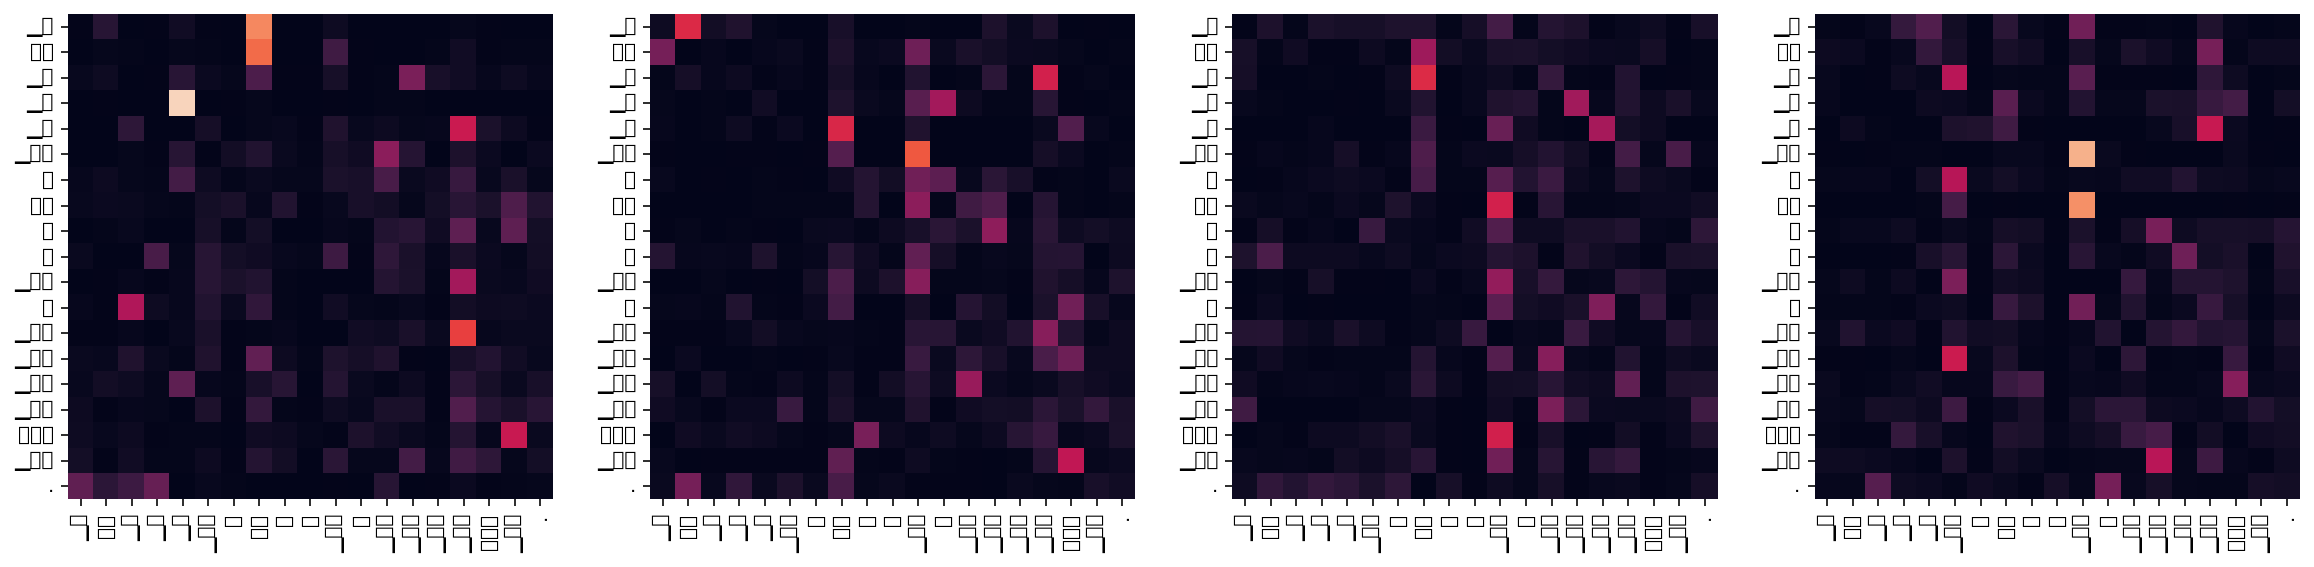

Encoder Layer 2


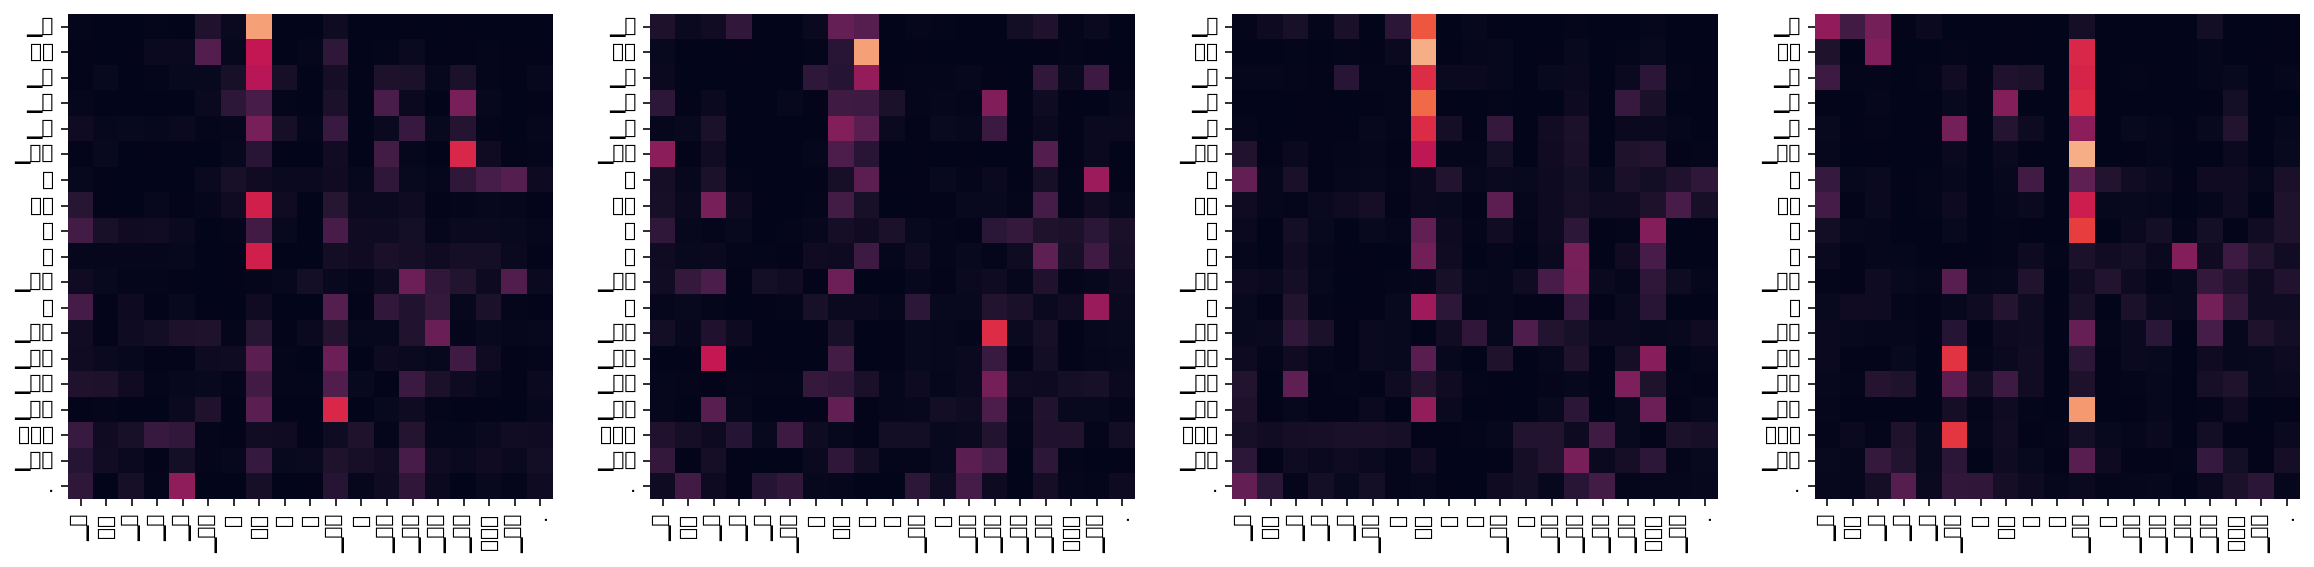

Decoder Self Layer 1


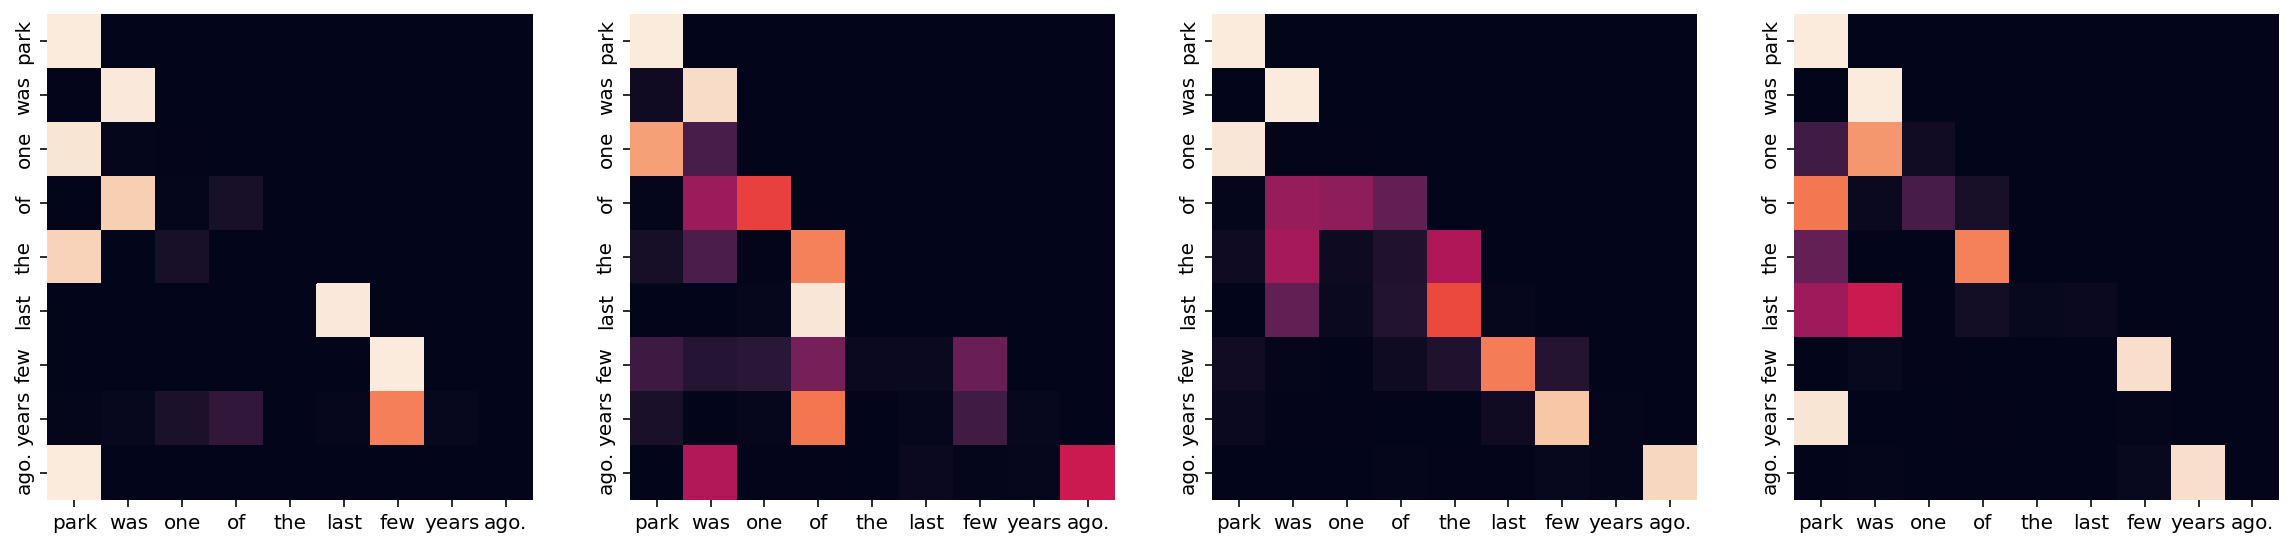

Decoder Src Layer 1


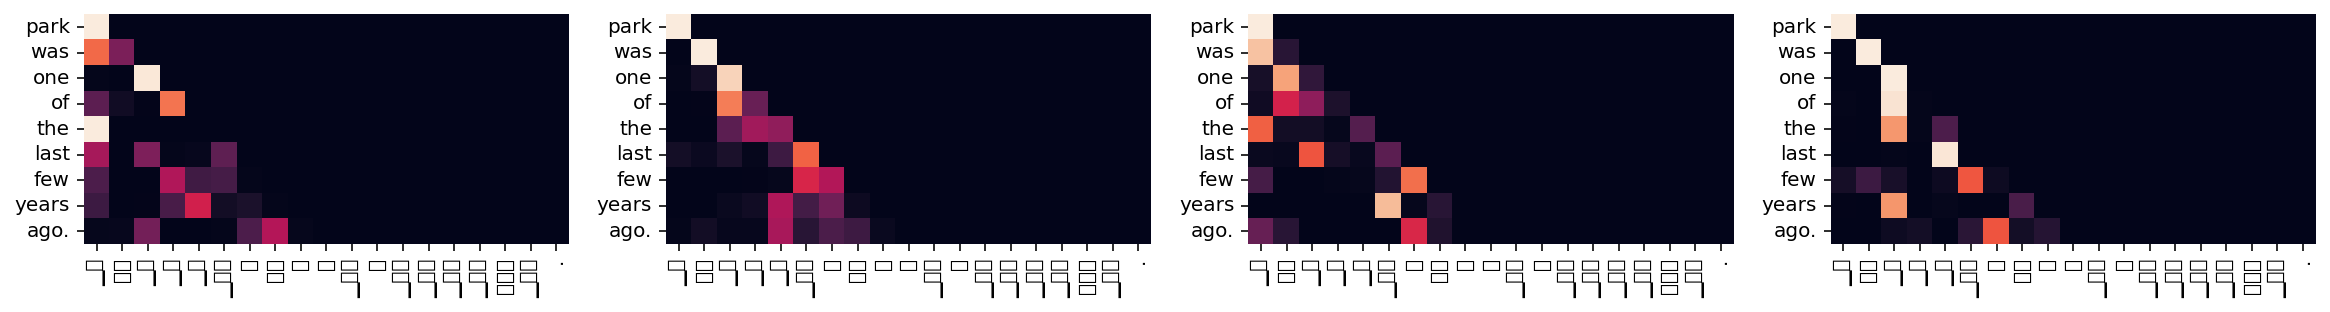

Decoder Self Layer 2


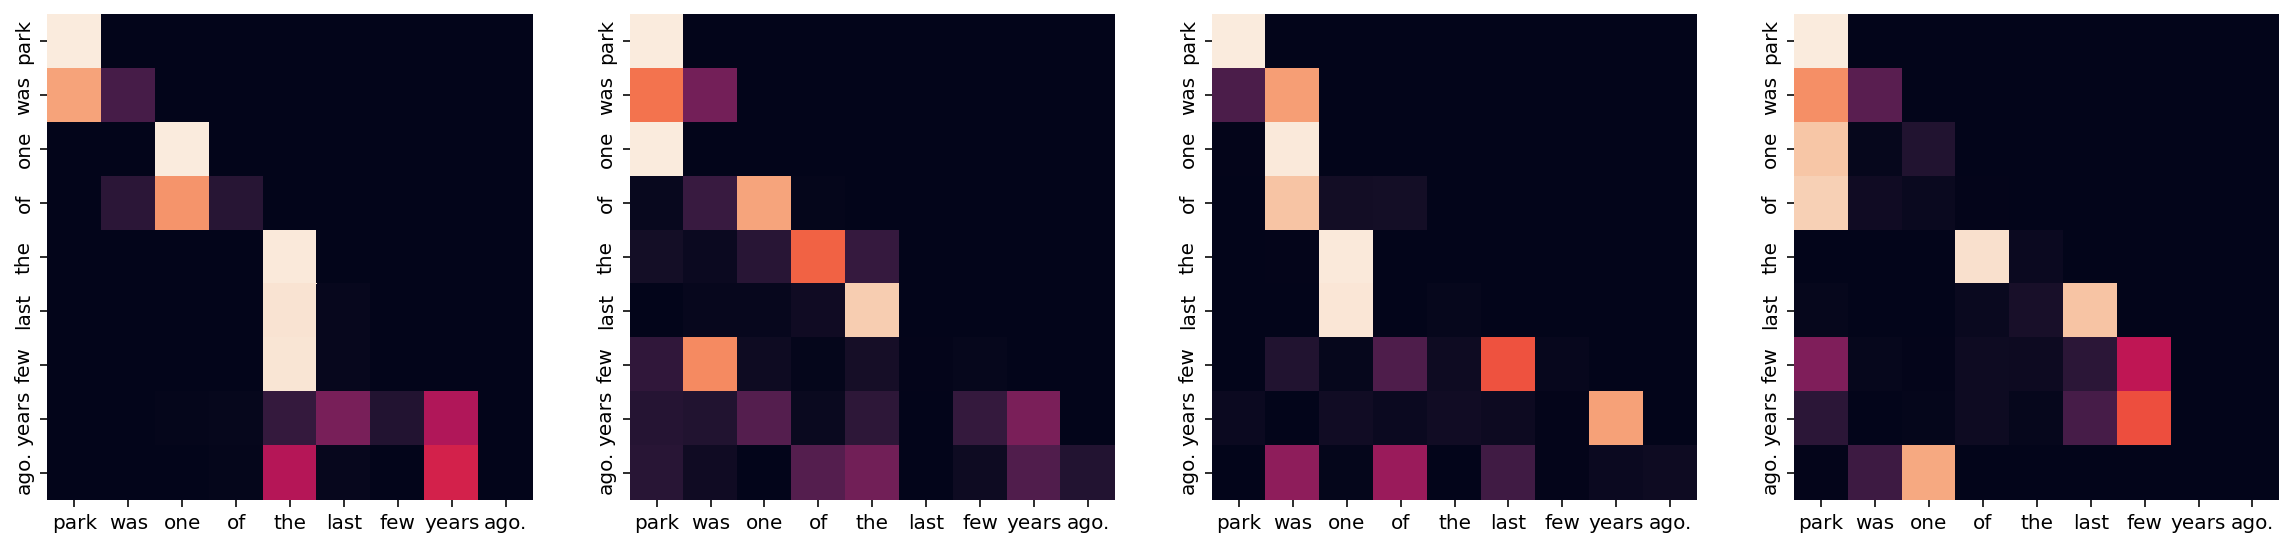

Decoder Src Layer 2


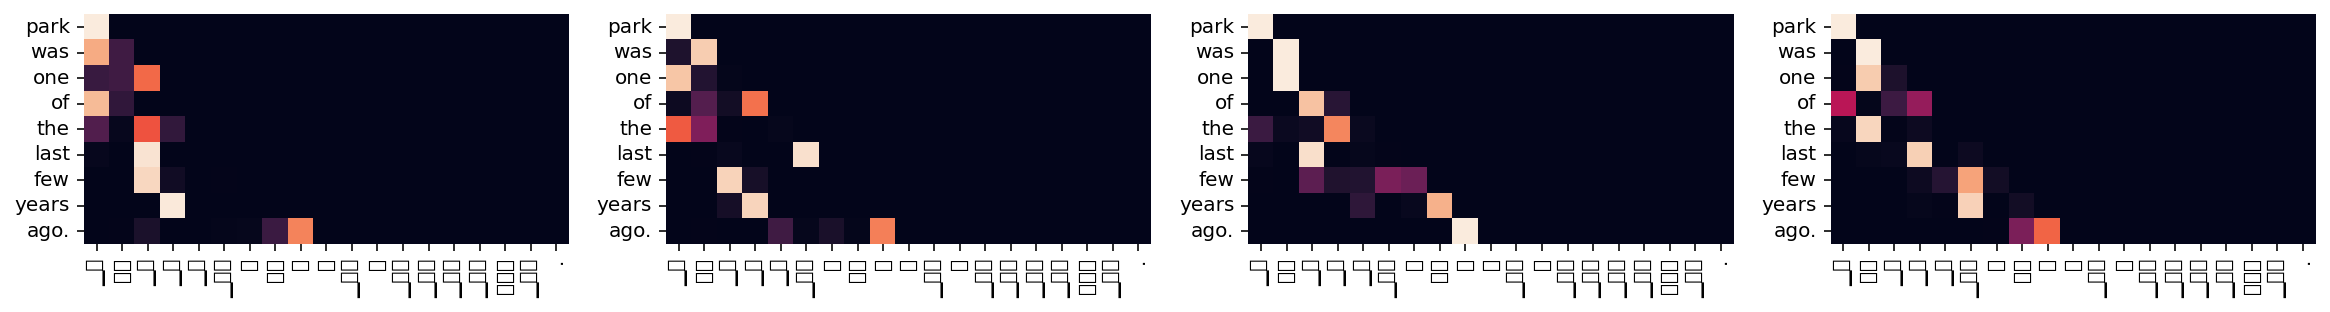

In [ ]:
# 학습

from tqdm import tqdm_notebook 

BATCH_SIZE = 64
EPOCHS = 30

examples = [
            "오바마는 대통령이다.",
            "시민들은 도시 속에 산다.",
            "커피는 필요 없다.",
            "일곱 명의 사망자가 발생했다.",
            "투표는 시민의 권리이다",
            "음주는 만성간염, 간경변증, 간암의 대표적인 원인이다.",
            "친환경 에너지 정책을 펼쳐온 미국 조 바이든 행정부가 올 들어 석탄 사용량을 늘린 것으로 나타났다.",
            "박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다."
]

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+BATCH_SIZE],
                    dec_train[idx:idx+BATCH_SIZE],
                    transformer,
                    optimizer)

        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

    for example in examples:
        translate(example, transformer, ko_tokenizer, en_tokenizer)
    
    if epoch == EPOCHS -1 : translate(example, transformer, ko_tokenizer, en_tokenizer, True)

# Report

Example sentences:
> 1. Obama is the president.
> 2. Citizens live in the city.
> 3. Coffee is not needed.
> 4. Seven deaths occurred.

Hyperparameters:
> n_layers: 2, d_model: 512, n_heads: 8, d_ff: 2048, dropout: 0.3

Training Parameters:
> Warmup Steps: 4000, Batch Size: 64, Epochs: 5

Results:

- Input: Obama is the president. / Output: obama is a teacher . (Incorrect)
- Input: Citizens live in the city. / Output: a country lives in a city . (Partially correct)
- Input: Coffee is not needed. / Output: the money is not required . (Partially correct)
- Input: Seven deaths occurred. / Output: seven workers had been deployed . (Incorrect)

The results indicate a need for more training data, hyperparameter tuning, and additional epochs to improve translation quality. The model captures some structural patterns but struggles with accurate content translation.
